# ResOpsBR: climate indices
***

**_Autor:_** Chus Casado Rodríguez<br>
**_Fecha:_** 18-07-2025<br>

**Introduction:**<br>
This notebook creates the static attributes for the catchmens of the reservoirs in the ResOpsBR dataset.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.auto import tqdm

from lisfloodreservoirs.utils import DatasetConfig
from lisfloodreservoirs.utils.plots import plot_attributes
from lisfloodreservoirs.utils.utils import duration_precip_indices

## Configuration

In [2]:
cfg = DatasetConfig('config_ResOpsBR_v11.yml')

# `cutmaps`
PATH_CUTMAPS = cfg.PATH_RESOPS / 'ancillary' / 'cutmaps'
OUTLETS = PATH_CUTMAPS / 'dams_gdw_3min.txt'

# `catchstats`
PATH_METEO = cfg.PATH_RESOPS / 'ancillary' / 'catchstats' / 'meteo'

# output
PATH_PLOTS = cfg.PATH_ATTRS / 'plots'
PATH_PLOTS.mkdir(parents=False, exist_ok=True)
print(f'Attribute tables will be saved in {cfg.PATH_ATTRS}')

Attribute tables will be saved in Z:\nahaUsers\casadje\datasets\reservoirs\ResOpsBR\v1.1\attributes


## Data

### Reservoirs

In [3]:
# load TXT used as input for `cutmaps`
reservoirs = pd.read_csv(OUTLETS, sep='\t', header=None)
reservoirs.columns = ['lon', 'lat', 'GDW_ID']
reservoirs.set_index('GDW_ID', drop=True, inplace=True)

print(f'{len(reservoirs)} reservoirs')

144 reservoirs


### Meteorology

In [4]:
# load areal meteo time series
meteo = {}
variables = [item.stem for item in PATH_METEO.glob('*') if item.is_dir() & (not item.stem.startswith('_'))]
for var in tqdm(variables):
    try:
        da = xr.open_mfdataset(f'{PATH_METEO}/{var}/*.nc')[f'{var}_mean'].compute()
        da.name = var
        da = da.rename({'id': 'ID'})
        meteo[var] = da
    except Exception as e:
        variables.remove(var)
        print(f'ERROR. While reading data for variable {var}:\n{e}')
        continue
meteo = xr.Dataset(meteo)
meteo = meteo.rename({'tp': 'precip', 'ta': 'temp', 'e0': 'pet'})

# compute precipitation as snowfall
meteo['snow'] = meteo['precip'].where(meteo['temp'] > 1, 0)

  0%|          | 0/3 [00:00<?, ?it/s]

## Attributes

In [7]:
# average of all meteo variables
attrs = meteo.mean('time').to_pandas()
attrs.columns = [f'{col}_mean' for col in attrs.columns]
attrs.index.name = 'GDW_ID'

# indices
attrs['aridity'] = attrs.precip_mean / attrs.pet_mean
attrs['frac_snow'] = attrs.snow_mean / attrs.precip_mean
attrs['moisture_index'] = attrs.precip_mean - attrs.pet_mean
precip_monthly = meteo['precip'].resample({'time': 'MS'}).sum().groupby('time.month').mean()
precip_annual = meteo['precip'].resample({'time': 'YS'}).sum().mean('time')
attrs['seasonality'] = ((precip_monthly.max('month') - precip_monthly.min('month')) / precip_annual).to_pandas()

# high and dry precipitation indices
precip_extremes = {
    'high': 20, # mm
    'low': 1 # mm
}
for key, value in precip_extremes.items():
    if key == 'high':
        mask_precip = meteo['precip'] > value
    elif key == 'low':
        mask_precip = meteo['precip'] < value
    attrs[f'{key}_precip_freq'] = mask_precip.sum('time') / len(meteo.time)
    attrs[f'{key}_precip_dur'] = duration_precip_indices(mask_precip.to_pandas())

### Plot

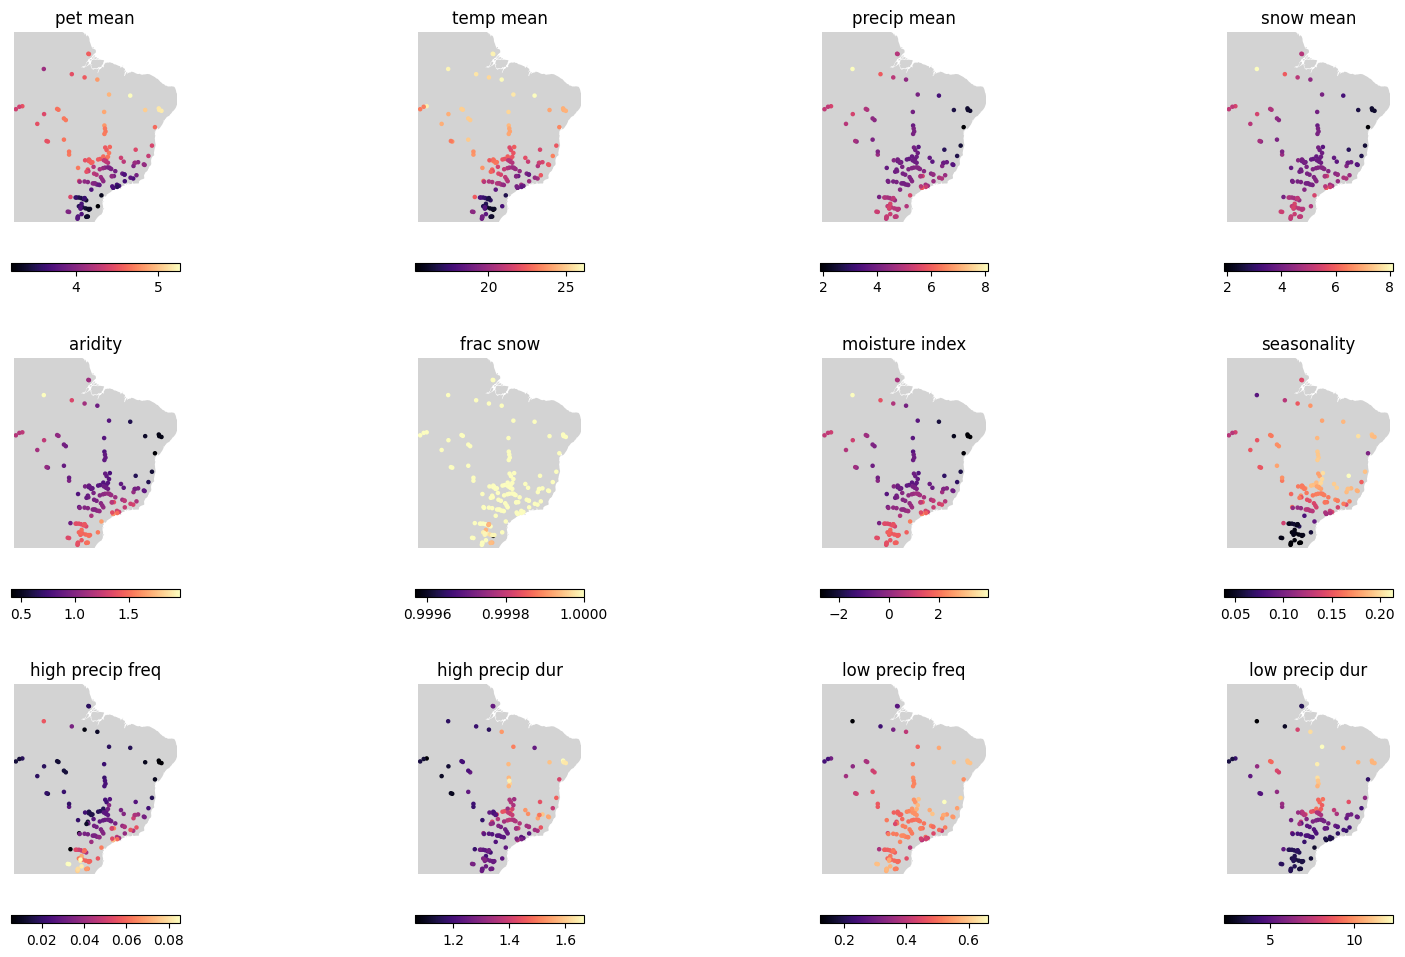

In [8]:
# plot attributes
r = 5
extent = [np.floor(reservoirs.lon.min() / r) * r, np.ceil(reservoirs.lon.max() / r) * r,
          np.floor(reservoirs.lat.min() / r) * r, np.ceil(reservoirs.lat.max() / r) * r]
plot_attributes(
    attrs,
    reservoirs.lon,
    reservoirs.lat,
    ncols=4,
    extent=extent,
    save=PATH_PLOTS / f'maps_climate.jpg'
)

### Export

In [9]:
# sort index
attrs.index.name = 'GDW_ID'
attrs.index = attrs.index.astype(int)
attrs.sort_index(axis=0, inplace=True)

print('{0} climate indices define the climatology of {1} catchments'.format(*attrs.shape[::-1]))

# export
attrs.to_csv(cfg.PATH_ATTRS / 'climate_indices.csv', float_format='%.6f')

12 climate indices define the climatology of 141 catchments
